In [744]:
import sys
# from re import split
sys.path.append('../../../')
import os
# import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from impedance.circuits import CustomCircuit
from impedance.plotting import plot_nyquist
from impedance import preprocessing
from impedance import validation

from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import brute
from scipy import optimize

import ImpedanceCorrection as IC
%reload_ext autoreload
%autoreload 2

In [ ]:
f0, Z0 = preprocessing.readVersaStudio(all_files[1])

freqs, Z = preprocessing.ignoreBelowX(f0, Z0)

Z = Z - Z[0]

In [773]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*.par')
all_files.sort()

f_name=all_files[1]
print(f_name)
f0, Z0= preprocessing.readVersaStudio(f_name)

freqs, Z1 = preprocessing.ignoreBelowX(f0, Z0)

Z = Z1 - Z1[0]

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par


Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
 active_mask: array([0, 0])
        cost: 0.32381278986566064
         fun: array([0.80475187])
        grad: array([ 0.        , 19.35825254])
         jac: array([[ 0.        , 24.05493314]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 17
        njev: 1
  optimality: 0.00656827320434278
      status: 3
     success: True
           x: array([3.00000000e+03, 3.40300936e-04])


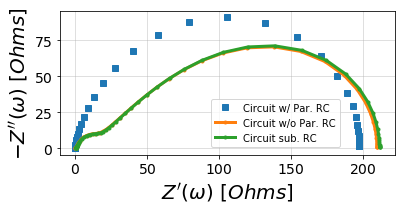

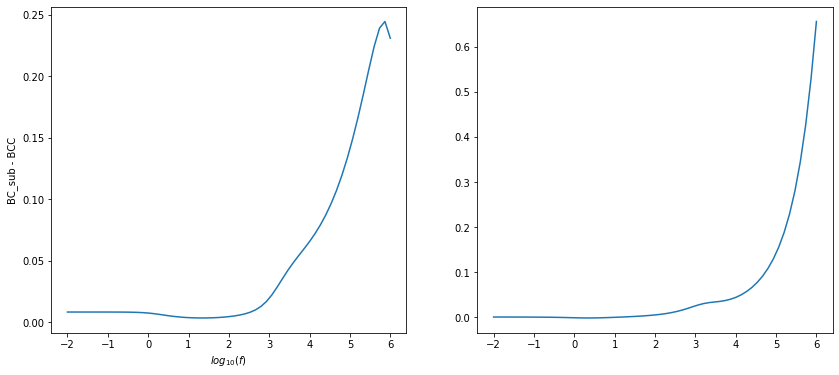

In [705]:
circ = 'p(C1,R1,p(R2,C2)-G1)'
circCorr = 'p(R2,C2)-G1'

vals = [3.4e-4, 3.4e3, 10, 1e-5, 200, .1]
valsCorr = [10, 1e-5, 200, .1]


pred_freq = np.logspace(np.log10(1e6), np.log10(1e-2), num = f0.size)

BertCirc = CustomCircuit(circ, initial_guess = vals)
BC_pred = BertCirc.predict(pred_freq)

BertCircCorr = CustomCircuit(circCorr, initial_guess = valsCorr)
BCC_pred = BertCircCorr.predict(pred_freq)

RC0 = np.array([3e3, 3e-4])
d_st = 3e-16
x_t = xtol=3e-16
f_t = ftol=3e-16
g_t = gtol=3e-16


resRC= least_squares(IC.Par_RC_Res, RC0, method= 'trf', args=(pred_freq, BC_pred), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)
# print(resRC)
resRC= least_squares(IC.Par_RC_Res, resRC.x, method= 'trf', args=(pred_freq, BC_pred), bounds=[(1e3, 1e-6), (1e4, 1e-3)] , max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)
print(resRC)

LS_only = IC.par_RC_subtract(resRC.x, pred_freq, BC_pred)


fig, ax0 = plt.subplots(figsize=(6,6))
plot_nyquist(ax0, pred_freq, BC_pred,fmt='s', label='Circuit w/ Par. RC')
plot_nyquist(ax0, pred_freq, BCC_pred, label='Circuit w/o Par. RC')
plot_nyquist(ax0, pred_freq, LS_only, label='Circuit sub. RC')
fig.legend(loc=(0.525,.3))
# fig.savefig('Figures\Corrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,6))
ax1.plot(np.log10(pred_freq), np.real((LS_only-BCC_pred)/BC_sub))
ax1.set_ylabel('BC_sub - BCC')
ax1.set_xlabel('$log_{10}(f)$')
# fig.savefig('Figures\Correction_Error.png', dpi=300, bbox_inches='tight')

ax2.plot(np.log10(pred_freq), np.imag((LS_only-BCC_pred)/BC_sub))

plt.show()

In [706]:
rrange = ((1e3, 1e4), (1e-4,1e-3))

bruteout100 = brute(IC.Par_RC_Res, rrange, Ns=100, args=(pred_freq, BC_pred), full_output=True)

resRCout = least_squares(IC.Par_RC_Res, bruteout100[0], method= 'trf', loss='soft_l1', args=(pred_freq, BC_pred), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)

Bru100_only = IC.par_RC_subtract(bruteout100[0], pred_freq, BC_pred)
LS_Bru100 = IC.par_RC_subtract(resRCout.x, pred_freq, BC_pred)

print(resRC, '\n', bruteout100[0],'\n', resRCout)

 active_mask: array([0, 0])
        cost: 0.32381278986566064
         fun: array([0.80475187])
        grad: array([ 0.        , 19.35825254])
         jac: array([[ 0.        , 24.05493314]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 17
        njev: 1
  optimality: 0.00656827320434278
      status: 3
     success: True
           x: array([3.00000000e+03, 3.40300936e-04]) 
 [1.18320906e+03 3.40300940e-04] 
  active_mask: array([0., 0.])
        cost: 0.2835986832534021
         fun: array([0.80475187])
        grad: array([ 0.        , 32.25063958])
         jac: array([[ 0.        , 35.37216998]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 28
        njev: 1
  optimality: 32.25063958406699
      status: 3
     success: True
           x: array([1.18320906e+03, 3.40300940e-04])


In [103]:
Yel = 1/BC_pred
RC = [-4, 8.2e-4]

w = IC.calcw(pred_freq)
Y = Yel - (1 / 10**RC[0]) #- RC[1] * (1j * w)


a = np.diff(Y)
b = np.diff(np.conj(Y))

s = np.real(np.sum(a*b))

LY = np.sqrt(s)

print(s, np.sum(a*b), np.sum(a), np.sum(b))
# print(np.real(np.sum(a*b)), '\n', a)

4078733.1952585806 (4078733.1952585806+0j) (-2.5588776499625965-5175.738328334173j) (-2.5588776499625965+5175.738328334173j)


In [642]:
subRs = np.logspace(3, 5, num=5)
ReaalC = 1e-4

corrs = []

for Rs in subRs:
    corrs.append(IC.par_RC_subtract([Rs, ReaalC], pred_freq, BC_pred))
    
BC_sub = IC.par_RC_subtract([10**3, ReaalC], pred_freq, BC_pred)

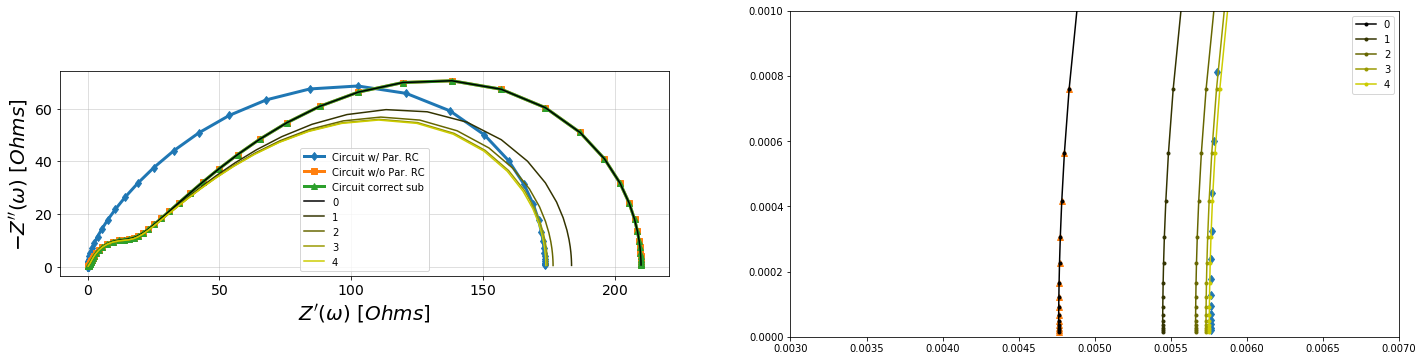

In [643]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(24,6))
plot_nyquist(ax0, pred_freq, BC_pred, fmt='-d', label='Circuit w/ Par. RC')
plot_nyquist(ax0, pred_freq, BCC_pred, fmt='-s', label='Circuit w/o Par. RC')
plot_nyquist(ax0, pred_freq, BC_sub, fmt='-^', label='Circuit correct sub')

Y_BC = 1/BC_pred
Y_BCC = 1/BCC_pred
Y_BCsub = 1/BC_sub

ax1.plot(Y_BC[:].real, Y_BC[:].imag, 'd')
# ax1.plot(Y_BCC[:].real, Y_BCC[:].imag, 's')
ax1.plot(Y_BCsub[:].real, Y_BCsub[:].imag, '^')

for n in range(len(corrs)):
    data = corrs[n]
    Y_corrs = 1/data
    ax0.plot(data.real, -data.imag, label=str(n), c=(n/len(corrs),n/len(corrs),0))
#     plot_nyquist(ax0, pred_freq, data)
    ax1.plot(Y_corrs[:].real, Y_corrs[:].imag, '.-', label=str(n), c=(n/len(corrs),n/len(corrs),0))

    
ax1.set_ylim(0,.001)
ax1.set_xlim(3e-3,7e-3)
ax0.legend()
ax1.legend()
# fig.legend(loc=(0.525,.3))

In [253]:
print(IC.calcS(BCC_pred), IC.calcS(corrs[0]), IC.calcS(corrs[-1]))

3075.765511855312 4483.752166485003 2760.1427818727107


In [275]:
print(np.sum(np.angle(1/BCC_pred)), np.sum(np.angle(1/corrs[0])), np.sum(np.angle(1/corrs[-1])))

34.52482794743445 35.31575385681275 34.20679530196696


In [266]:
print(np.sum(np.angle(BCC_pred)*np.abs(BCC_pred)), np.sum(np.angle(corrs[0])*np.abs(corrs[0])), np.sum(np.angle(corrs[-1])*np.abs(corrs[-1])))

-1125.5756356124305 -1317.4933819166022 -1056.615650499428


In [563]:
rrange = ((2, 4), (-5,-3))
bruteout10 = brute(IC.Par_RC_Res_log, rrange, Ns=3, args=(pred_freq, BC_pred), full_output=True)

duma = bruteout10[2]
man_brute=[]
prams=[]

for i in range(duma.shape[1]):
    for j in range(duma.shape[2]):
#         print(duma[:,i,j])
        prams.append(duma[:,i,j])
        man_brute.append(IC.par_RC_subtract_log(duma[:,i,j], pred_freq, BC_pred))
        
prams = np.array(prams)
man_brute = np.array(man_brute)

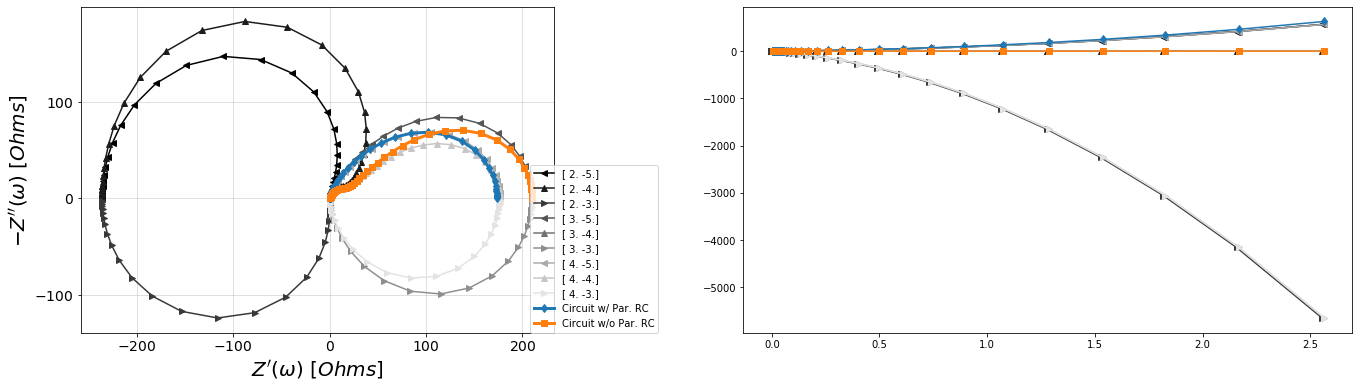

In [568]:
# syms = ['<-', '^-', '>-']
syms = ['<-', '^-', '>-', 'v-', 'o-', '.-', '<--', '^--', '>--', 'v--']

Cmax = prams[len(prams)-1][0]
Rmax = prams[len(prams)-1][1]
pramlen = int(np.sqrt(len(prams)))

Y_BC = 1/BC_pred
Y_BCC = 1/BCC_pred
Y_BCsub = 1/BC_sub

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(24,6))

for n in range(len(man_brute)):
    data = man_brute[n]
#     print(data.real)
    Y_corrs = 1/data
    ax0.plot(data.real, -data.imag, syms[np.mod(n, pramlen)], label=str(prams[n]), c=(n/len(prams), n/len(prams), n/len(prams)))
    ax1.plot(Y_corrs[:].real, Y_corrs[:].imag, syms[np.mod(n, pramlen)], label=str(prams[n]), c=(n/len(prams), n/len(prams), n/len(prams)))

plot_nyquist(ax0, pred_freq, BC_pred, fmt='-d', label='Circuit w/ Par. RC')
plot_nyquist(ax0, pred_freq, BCC_pred, fmt='-s', label='Circuit w/o Par. RC')

ax1.plot(Y_BC[:].real, Y_BC[:].imag, '-d', label='Circuit w/ Par. RC')
ax1.plot(Y_BCC[:].real, Y_BCC[:].imag, '-s', label='Circuit w/o Par. RC')

    
# ax1.set_ylim(0,.01)
# ax1.set_xlim(3e-3,2e-2)
ax0.legend(loc=(.95,0))
# ax1.legend()
# fig.legend(loc=(0.525,.3))

plt.show()

# Real Data

In [742]:
rrange = ((3.5,9.5), (-6,-5))
bruteout10 = brute(IC.Par_RC_Res_log, rrange, Ns=10, args=(freqs[1:], Z[1:]), full_output=True)

duma = bruteout10[2]
man_brute=[]
prams=[]

for i in range(duma.shape[1]):
    for j in range(duma.shape[2]):
#         print(duma[:,i,j])
        prams.append(duma[:,i,j])
        man_brute.append(IC.par_RC_subtract_log(duma[:,i,j], freqs[1:], Z[1:]))
        
prams = np.array(prams)
man_brute = np.array(man_brute)
bruteout10[0]

array([ 3.12571585, -5.84293771])

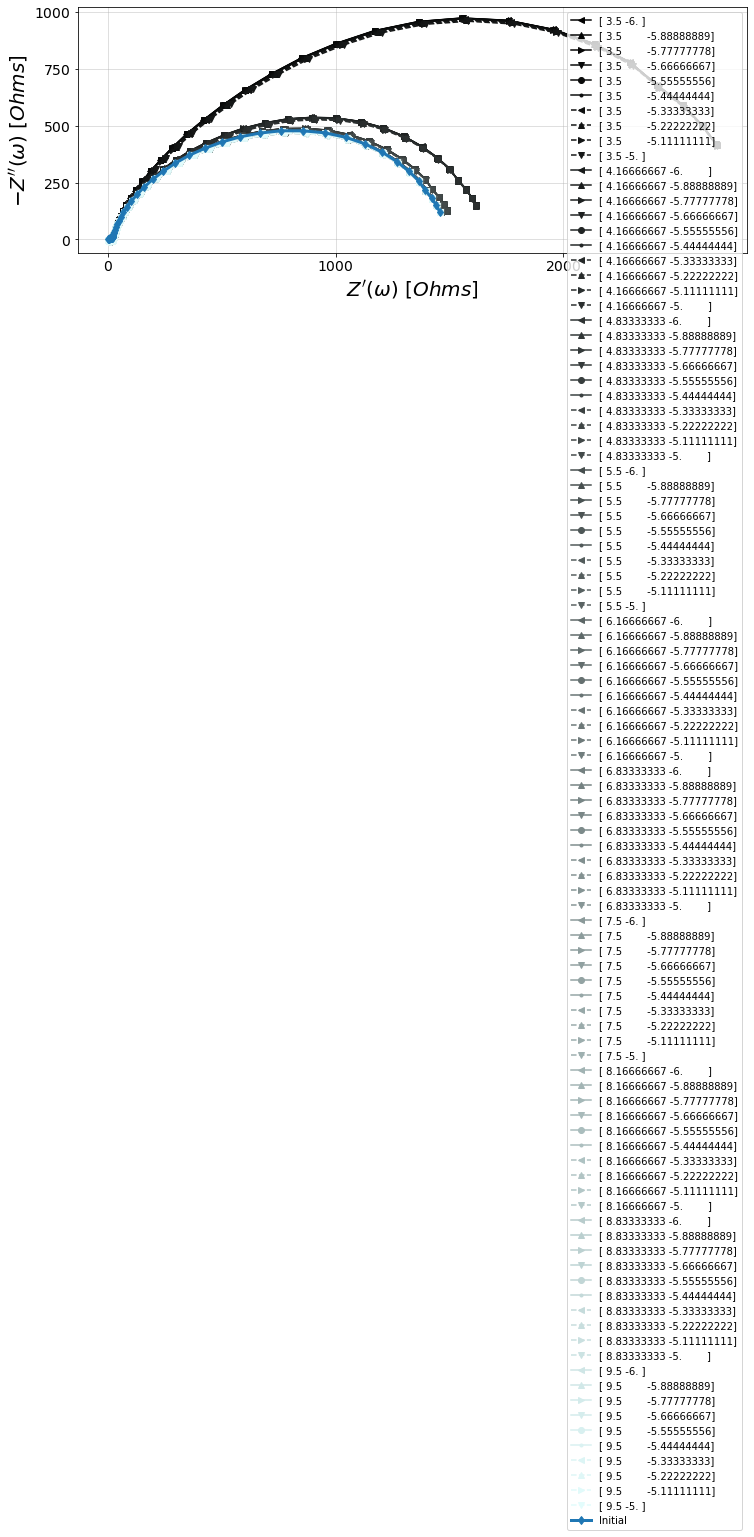

In [743]:
Cmax = prams[len(prams)-1][0]
Rmax = prams[len(prams)-1][1]
pramlen = int(np.sqrt(len(prams)))

Y = 1/Z[1:]

# fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(24,12))
fig, ax0 = plt.subplots(figsize=(12,12))

for n in range(len(man_brute)):
    data = man_brute[n]
#     print(data.real)
    Y_corrs = 1/data
    if prams[n, 0] >= prams[0, 0]:
        ax0.plot(data.real, -data.imag, syms[np.mod(n, pramlen)], label=str(prams[n]), c=(n/len(prams)*.9, n/len(prams), n/len(prams)))
#     ax1.plot(Y_corrs[:].real, Y_corrs[:].imag, syms[np.mod(n, pramlen)], label=str(prams[n]), c=(n/len(prams)*.9, n/len(prams), n/len(prams)))

plot_nyquist(ax0, freqs, Z, fmt='-d', label='Initial')
# ax1.plot(Y[:].real, Y[:].imag, '-d', label='Initial')

    
# ax1.set_ylim(0,.01)
# ax1.set_xlim(3e-3,2e-2)
# ax0.legend(loc=(.95,0))
ax0.legend()
# ax0.set_xlim((-50,100))
# ax0.set_ylim((-50,100))
# fig.legend(loc=(0.525,.3))

plt.show()

In [748]:
KK[2]

array([   2.37810881  -2.17180205j,    2.59190046  -2.76106375j,
          2.93349147  -3.47540701j,    3.46491468  -4.306533j  ,
          4.25831668  -5.21093568j,    5.37291378  -6.09309274j,
          6.81195142  -6.80739702j,    8.4802678   -7.20233004j,
         10.18965205  -7.20002327j,   11.7341605   -6.85026572j,
         12.98106102  -6.30424579j,   13.90335083  -5.73638144j,
         14.54961529  -5.28436379j,   14.998014    -5.03479102j,
         15.32698597  -5.03662611j,   15.60598169  -5.31940789j,
         15.89762356  -5.90525674j,   16.26301169  -6.81241515j,
         16.76371393  -8.05148166j,   17.45422218  -9.61863412j,
         18.36113312 -11.49664249j,   19.45761304 -13.67976688j,
         20.66067068 -16.2261016j ,   21.87440102 -19.30704112j,
         23.05851159 -23.21291366j,   24.27486831 -28.318183j  ,
         25.70006984 -35.04771165j,   27.63426321 -43.86619936j,
         30.53699313 -55.27562253j,   35.10043754 -69.78741631j,
         42.35023874 -87.

In [752]:
KK

(5,
 -0.0624665850473225,
 array([   2.37810881  -2.17180205j,    2.59190046  -2.76106375j,
           2.93349147  -3.47540701j,    3.46491468  -4.306533j  ,
           4.25831668  -5.21093568j,    5.37291378  -6.09309274j,
           6.81195142  -6.80739702j,    8.4802678   -7.20233004j,
          10.18965205  -7.20002327j,   11.7341605   -6.85026572j,
          12.98106102  -6.30424579j,   13.90335083  -5.73638144j,
          14.54961529  -5.28436379j,   14.998014    -5.03479102j,
          15.32698597  -5.03662611j,   15.60598169  -5.31940789j,
          15.89762356  -5.90525674j,   16.26301169  -6.81241515j,
          16.76371393  -8.05148166j,   17.45422218  -9.61863412j,
          18.36113312 -11.49664249j,   19.45761304 -13.67976688j,
          20.66067068 -16.2261016j ,   21.87440102 -19.30704112j,
          23.05851159 -23.21291366j,   24.27486831 -28.318183j  ,
          25.70006984 -35.04771165j,   27.63426321 -43.86619936j,
          30.53699313 -55.27562253j,   35.10043754

(50, 0.009129082344941586)


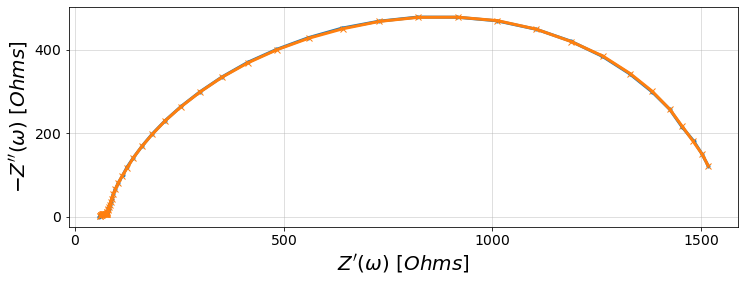

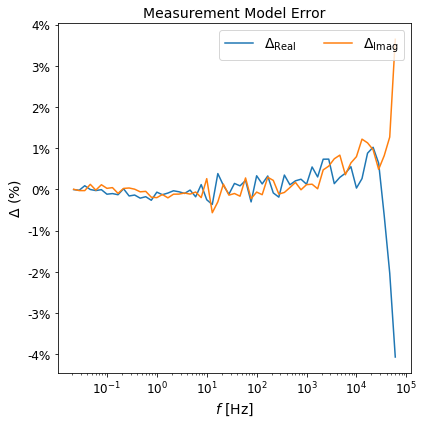

In [787]:
KK = validation.linKK(freqs, Z1, c=None)
print(KK[:2])
fig, ax0 = plt.subplots(ncols=1, figsize=(12,12))
fig2, ax2 = plt.subplots(ncols=1, figsize=(6,6))

plot_nyquist(ax0, freqs, Z1)
plot_nyquist(ax0, freqs, KK[2], fmt='-x')

# Plot residuals
ax2.plot(freqs, KK[3], '-', label=r'$\Delta_{\mathrm{Real}}$')
ax2.plot(freqs, KK[4], '-', label=r'$\Delta_{\mathrm{Imag}}$')
ax2.set_title('Measurement Model Error', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylabel('$\Delta$ $(\%)$', fontsize=14)
ax2.set_xlabel('$f$ [Hz]', fontsize=14)
ax2.set_xscale('log')
# ax2.set_ylim(-.2, .2)
ax2.legend(loc=1, fontsize=14, ncol=2)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:.0%}'.format(x) for x in vals])
plt.tight_layout()

plt.show()

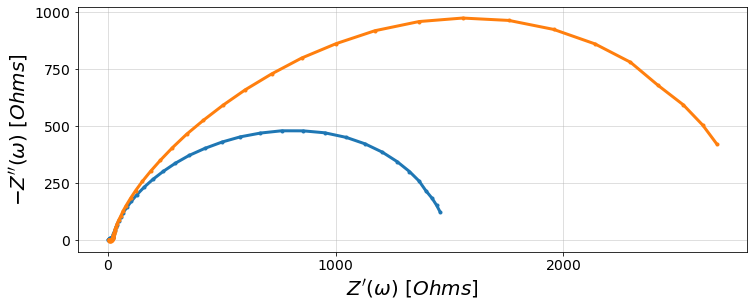

In [731]:
B_fit = IC.par_RC_subtract_log([3.5, -5.8429], freqs[1:], Z[1:])

fig, ax0 = plt.subplots(figsize=(12,12))

plot_nyquist(ax0, freqs, Z)
plot_nyquist(ax0, freqs[1:], B_fit)


In [792]:
direc = r'D:\UW Research\fr-XAS July 2018\Data\Versastat'

all_files=glob.glob(direc + '\*1%_EIS*.par')
all_files.sort()

all_files

['D:\\UW Research\\fr-XAS July 2018\\Data\\Versastat\\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before.par',
 'D:\\UW Research\\fr-XAS July 2018\\Data\\Versastat\\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par',
 'D:\\UW Research\\fr-XAS July 2018\\Data\\Versastat\\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2_Test.par',
 'D:\\UW Research\\fr-XAS July 2018\\Data\\Versastat\\LSC_DPB1_FRXAS_700C_1%_EIS_n100mV.par',
 'D:\\UW Research\\fr-XAS July 2018\\Data\\Versastat\\LSC_DPB1_FRXAS_700C_1%_EIS_n140mV.par',
 'D:\\UW Research\\fr-XAS July 2018\\Data\\Versastat\\LSC_DPB1_FRXAS_700C_1%_EIS_n150mV.par',
 'D:\\UW Research\\fr-XAS July 2018\\Data\\Versastat\\LSC_DPB1_FRXAS_700C_1%_EIS_n50mV.par',
 'D:\\UW Research\\fr-XAS July 2018\\Data\\Versastat\\LSC_DPB1_FRXAS_700C_1%_EIS_p100mV.par',
 'D:\\UW Research\\fr-XAS July 2018\\Data\\Versastat\\LSC_DPB1_FRXAS_700C_1%_EIS_p150mV.par',
 'D:\\UW Research\\fr-XAS July 2018\\Data\\Versastat\\LSC_DPB1_FRXAS_700C_1%_EIS_p50mV.par']

In [841]:
fs = []
Zs = []

for f_name in all_files:
    f0, Z0 = preprocessing.readVersaStudio(f_name)
    
    fi, Zi = preprocessing.ignoreBelowX(f0, Z0)
    
    fs.append(fi)
    Zs.append(Zi)

In [850]:
KKs = []

for i, (fi,Zi) in enumerate(zip(fs, Zs)):
    print(all_files[i])
    KKi = validation.linKK(fi, Zi, c=None, max_M=12)
    KKs.append(KKi)

D:\UW Research\fr-XAS July 2018\Data\Versastat\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before.par
D:\UW Research\fr-XAS July 2018\Data\Versastat\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par
D:\UW Research\fr-XAS July 2018\Data\Versastat\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2_Test.par
D:\UW Research\fr-XAS July 2018\Data\Versastat\LSC_DPB1_FRXAS_700C_1%_EIS_n100mV.par
D:\UW Research\fr-XAS July 2018\Data\Versastat\LSC_DPB1_FRXAS_700C_1%_EIS_n140mV.par
D:\UW Research\fr-XAS July 2018\Data\Versastat\LSC_DPB1_FRXAS_700C_1%_EIS_n150mV.par
D:\UW Research\fr-XAS July 2018\Data\Versastat\LSC_DPB1_FRXAS_700C_1%_EIS_n50mV.par
D:\UW Research\fr-XAS July 2018\Data\Versastat\LSC_DPB1_FRXAS_700C_1%_EIS_p100mV.par
D:\UW Research\fr-XAS July 2018\Data\Versastat\LSC_DPB1_FRXAS_700C_1%_EIS_p150mV.par
D:\UW Research\fr-XAS July 2018\Data\Versastat\LSC_DPB1_FRXAS_700C_1%_EIS_p50mV.par


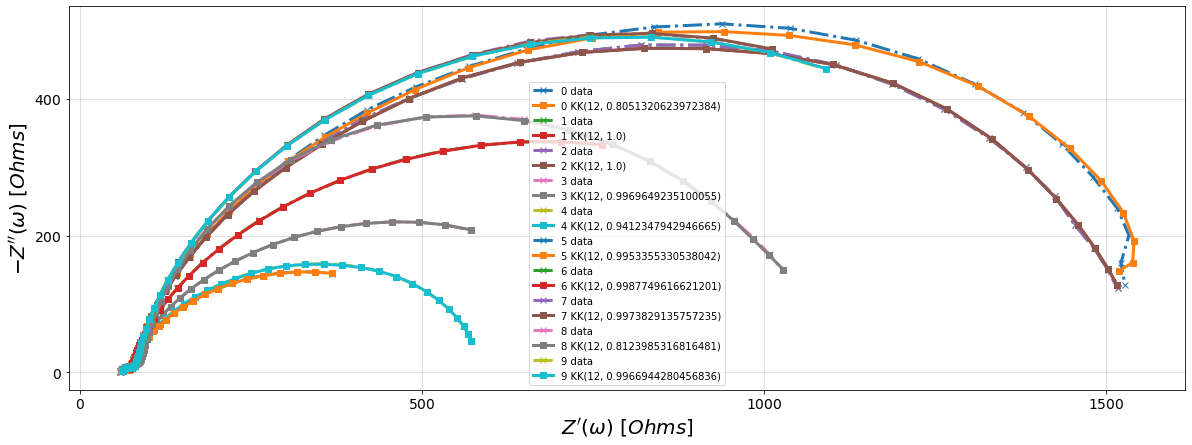

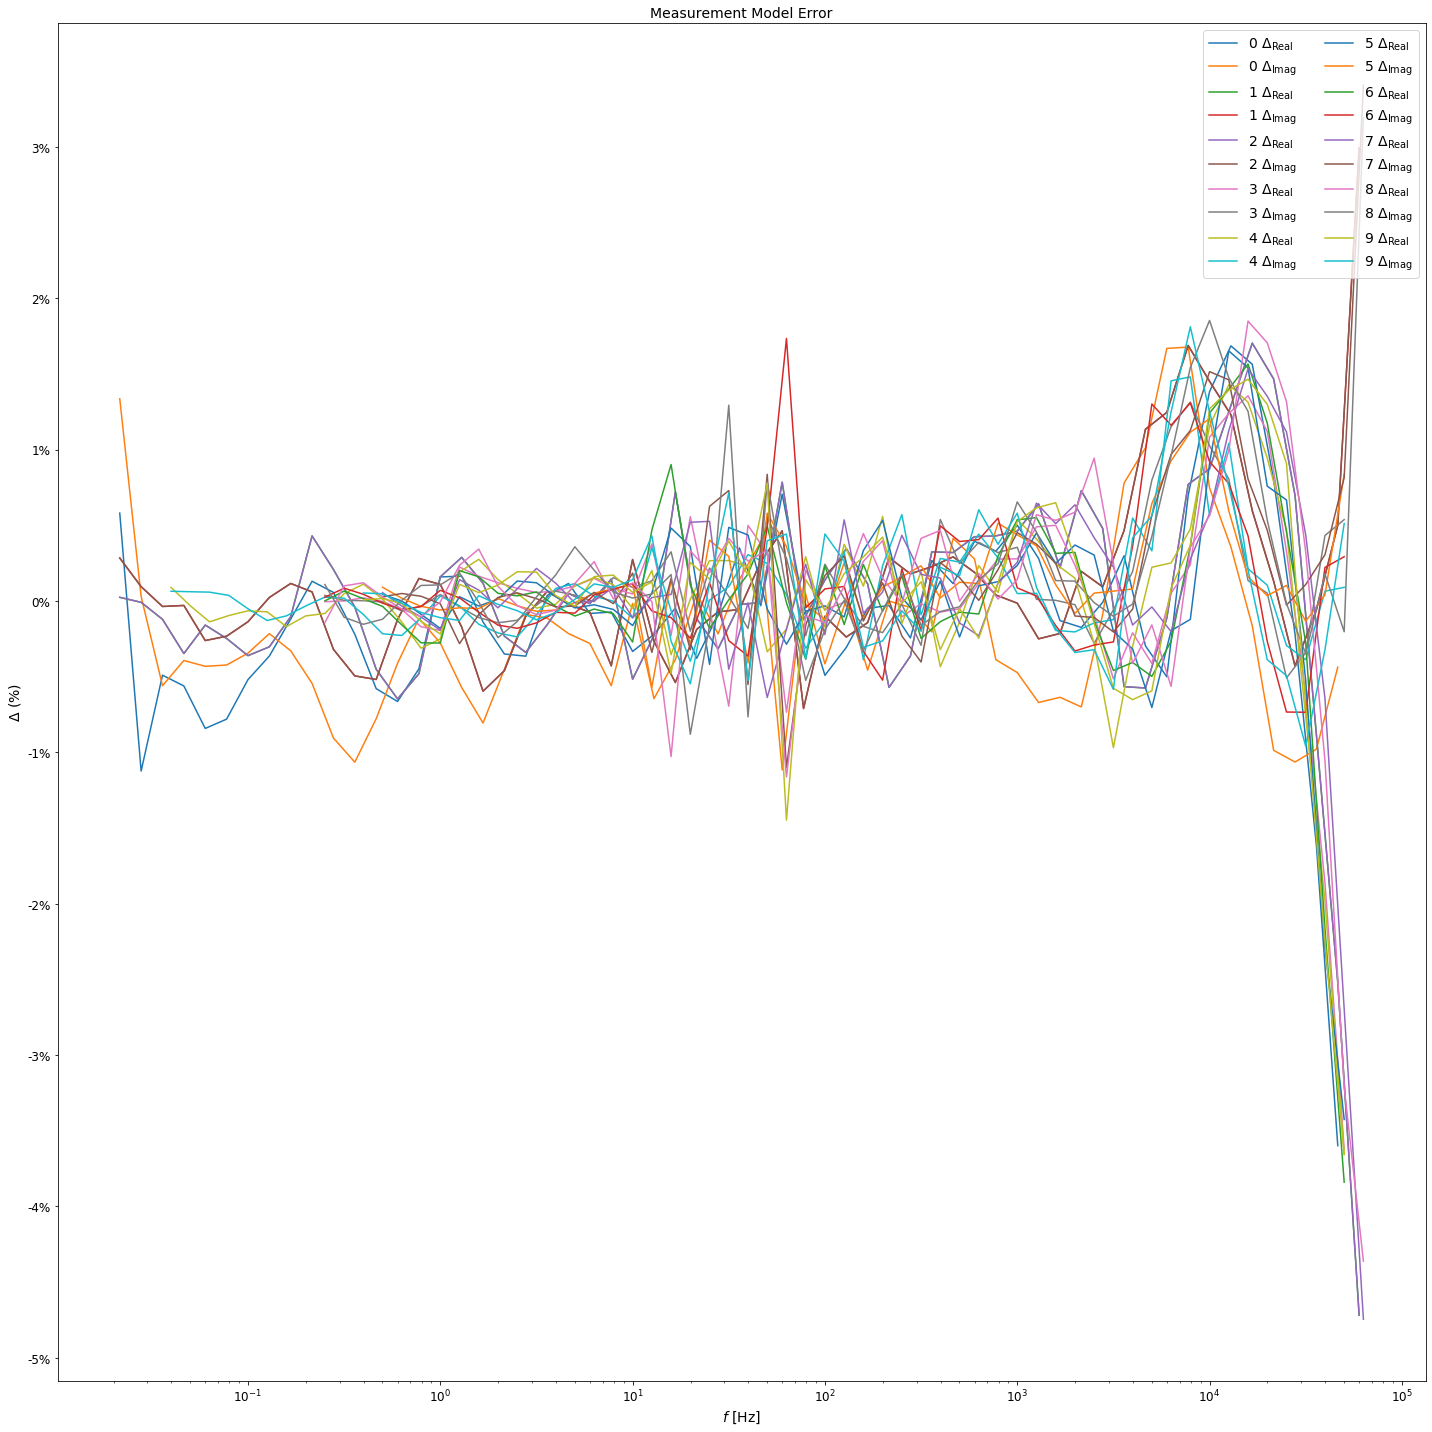

In [851]:
fig, ax0 = plt.subplots(figsize=(20,20))
fig2, ax2 = plt.subplots(figsize=(20,20))

for i, (fi,Zi) in enumerate(zip(fs, Zs)):
    plot_nyquist(ax0, fi, Zi, fmt='-.x', label= str(i)+' data')
    plot_nyquist(ax0, fi, KKs[i][2], fmt='-s', label=str(i)+' KK' + str(KKs[i][:2]))
    ax2.plot(fi, KKs[i][3], '-', label=str(i) + r' $\Delta_{\mathrm{Real}}$')
    ax2.plot(fi, KKs[i][4], '-', label=str(i) + r' $\Delta_{\mathrm{Imag}}$')

ax0.legend()


ax2.set_title('Measurement Model Error', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylabel('$\Delta$ $(\%)$', fontsize=14)
ax2.set_xlabel('$f$ [Hz]', fontsize=14)
ax2.set_xscale('log')
# ax2.set_ylim(-.2, .2)
ax2.legend(loc=1, fontsize=14, ncol=2)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:.0%}'.format(x) for x in vals])
plt.tight_layout()

plt.show()

In [825]:
N = 10
circuit = 'R_0'
initial_guess = [.015]
for i in range(N):
    circuit += f'-p(R_{i % 9 + 1},C_{i % 9 + 1})'
    initial_guess.append(.03/N)
    initial_guess.append(10**(3 - 6*i/N))

meas_model = CustomCircuit(initial_guess=initial_guess, circuit=circuit)


In [853]:
meas_model.fit(fs[0], Zs[0])

KeyboardInterrupt: 

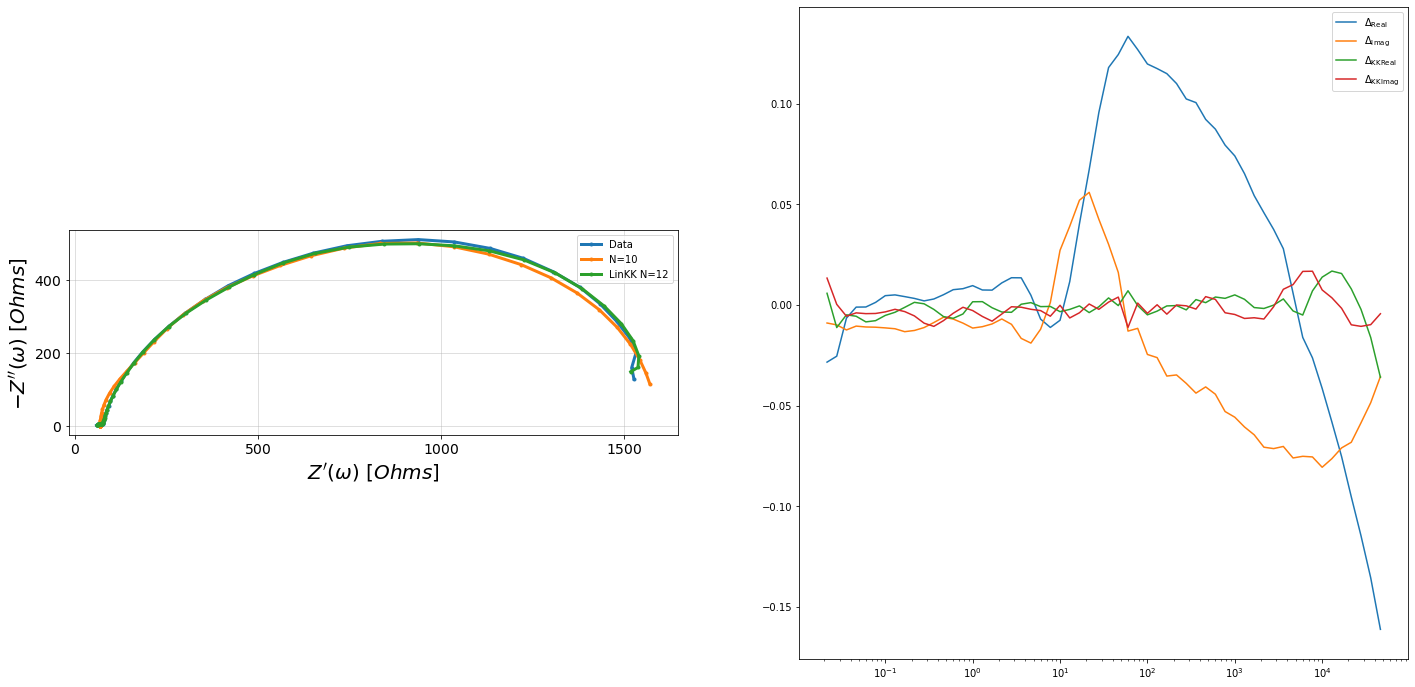

In [854]:
res_meas_real = (Zs[0] - meas_model.predict(fs[0])).real/np.abs(Zs[0])
res_meas_imag = (Zs[0] - meas_model.predict(fs[0])).imag/np.abs(Zs[0])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(24,12))

plot_nyquist(ax0, fs[0], Zs[0], label='Data')
plot_nyquist(ax0, fs[0], meas_model.predict(fs[0]), label='N=10')
plot_nyquist(ax0, fs[0], KKs[0][2], label='LinKK N='+str(KKs[0][0]))
ax0.legend()


ax1.plot(fs[0], res_meas_real, '-', label=r'$\Delta_{\mathrm{Real}}$')
ax1.plot(fs[0], res_meas_imag, '-', label=r'$\Delta_{\mathrm{Imag}}$')
ax1.plot(fs[0], KKs[0][3], '-', label=r'$\Delta_{\mathrm{ KK Real}}$')
ax1.plot(fs[0], KKs[0][4], '-', label=r'$\Delta_{\mathrm{ KK Imag}}$')

ax1.set_xscale('log')
ax1.legend()

plt.show()